In [1]:
from Data_preparation import data_processing_with_BH_scaled
import numpy as np
# from Design_Matrix import Dmat_einsum, get_design_mat
import torch
import gpytorch
import os
# from Design_Matrix import 
import matplotlib.pyplot as plt
from gpytorch.kernels import ProductKernel, ScaleKernel
from gpytorch.kernels.keops import MaternKernel
import cloudpickle
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution, DeltaVariationalDistribution
from gpytorch.variational import VariationalStrategy
from glob import glob
from scipy.special import eval_sh_legendre, eval_sh_jacobi
from torch.optim import Adam

from matplotlib.ticker import AutoMinorLocator, LogLocator


# dir_path = os.path.dirname(os.path.realpath(__file__))
cwd = os.getcwd()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float32

plots_folder = cwd# =============================================================================
import cloudpickle
from glob import glob

def Pickle_file(folder, filename, data):
    with open(folder + filename + '.pkl', mode='wb') as file:
        cloudpickle.dump(data, file)
        
def Unpickle_file(folder,filename):
    with open(folder+ filename + '.pkl', mode='rb') as file:
        data = cloudpickle.load(file)
    return data

plots_folder = glob("..\\Plots\\")[0]
pickles_folder = glob("..\\Pickles\\")[0]

In [2]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [3]:
# =============================================================================
# Load data
# =============================================================================
dis_depth = 185
num_vertical_des_points = 438 
num_cpts_w_bhs = 30   # 5 bhs + (num-5) cpts

bh_ids = [0, 1, 12, 21, 27] # for 30
num_bhs = 5

data, xt, yt, zt, grid, \
    z_mat, mapping, Dxy, Dz, depth_0 = data_processing_with_BH_scaled(
        num_cpts_w_bhs, num_bhs, 
        dis_depth, 
        num_vertical_des_points,
        cpt_par = "Ic")

In [4]:
# Leave some cpts out for testing

ids = [i for i in range(data.shape[1])]
cpt_ids = [i for i in ids if i not in bh_ids]

data[:, [i for i in ids if i not in bh_ids]] = np.log(data[:, 
                                                           [i for i in ids if
                                                            i not in bh_ids]])   
depth_points = (grid[0] * (Dz - depth_0) + depth_0).numpy()


cpt_test_ids = [8, 16, 20, 24, 28]
excl_ids = [2, 13, 25, 26, 28]

data_test = data[:, cpt_test_ids]
data  = data[:, [i for i in ids if i not in cpt_test_ids+excl_ids]]

xt_test = xt[cpt_test_ids]
yt_test = yt[cpt_test_ids]

grid[1] = grid[1][[i for i in ids if i not in cpt_test_ids+excl_ids]]
grid[2] = grid[2][[i for i in ids if i not in cpt_test_ids+excl_ids]]


# -----------------------------------------------------------------------------
# do it automatically not hardcoding
ids = [i for i in range(data.shape[1])]
bh_ids = [0, 1, 10, 16, 19]
cpt_ids = [i for i in ids if i not in bh_ids]



# create the train_x sets

data_cpts = data[:, cpt_ids]
y_nonnan_cpts = data_cpts.T.ravel()
y_nonnan_cpts = y_nonnan_cpts[~np.isnan(y_nonnan_cpts)]
len_nonnan_cpts = len(y_nonnan_cpts)
# create the train_x for cpts
depth_points = (grid[0] * (Dz - depth_0) + depth_0).numpy()

train_x_cpts = torch.zeros((len_nonnan_cpts, 3), dtype = dtype)
rowind = 0; 
for i, dat in enumerate(data_cpts.T):
    idni = len(dat[~np.isnan(dat)])

    train_x_cpts[rowind:rowind+idni, 0] = grid[0][:idni]
    train_x_cpts[rowind:rowind+idni, 1] = grid[1][cpt_ids[i]]
    train_x_cpts[rowind:rowind+idni, 2] = grid[2][cpt_ids[i]]
    rowind +=idni





# Standardize Ic data
mu_cpt = np.mean(np.exp(y_nonnan_cpts))
std_cpt = np.std(np.exp(y_nonnan_cpts))

def pars_log(mu_x,std_x):
    std_x_log = np.sqrt(np.log(std_x**2/mu_x**2 +1))
    mu_x_log = np.log(mu_x)-(std_x_log**2)/2    
    return mu_x_log,std_x_log

mu_cpt_log, std_cpt_log = pars_log(mu_cpt, std_cpt) 

# data_cpts_stdzd = (data_cpts - mu_cpt_log) / std_cpt_log
data_cpts_stdzd = (y_nonnan_cpts.reshape(-1, 1) - mu_cpt_log) / std_cpt_log
data_test_cpts_stdzd = (data_test- mu_cpt_log)/ std_cpt_log


depth_points = (grid[0] * (Dz - depth_0)+ depth_0).numpy()
depth_max = np.max(depth_points)


train_y = torch.tensor(data_cpts_stdzd, dtype = dtype).squeeze()

In [5]:
drop_ids = [5,6,8,10,12,14,15,16,17,18,19]

def get_design_mat_1d(loc, deg):
    H = torch.tensor(np.array([eval_sh_legendre(n, loc) for n in range(deg)]).T, dtype = dtype)
    return H
   
class Legendre_poly(gpytorch.means.Mean):
    # currently works for constant trent in horizntal!!
    def __init__(self, mx, my, mz):
        super().__init__()
        self.register_parameter(name="weights", parameter=torch.nn.Parameter( 
            torch.tensor([ 0.79351765,  0.01470026,  0.02857058,  
                          0.01003345, -0.11055545, -0.12710841,
                          0.12524614, -0.04141932,  0.02043685, 
                          -0.04141932,   0.02043685, -0.04141932,     
                          0.02043685, -0.04141932,  0.02043685, 
                          0.01470026,  0.02857058,  0.01003345, 
                          -0.11055545, -0.12710841, 0.12524614,
                          -0.04141932,  0.02043685, -0.04141932,  
                          0.02043685], dtype=dtype)[:mz]))
        self.mx = mx
        self.my = my
        self.mz = mz

        
    def Dmat(self, x):

        Phi11 = get_design_mat_1d(x[:,1].view(-1,1).detach().cpu().numpy(), self.mx ).squeeze(0)
        Phi22 = get_design_mat_1d(x[:,2].view(-1,1).detach().cpu().numpy(), self.my ).squeeze(0)
 
        Phi_h = torch.einsum('ik,il->ikl', Phi11, Phi22).squeeze(-1).to(device)
        
        Phi_v = get_design_mat_1d(x[:,0].view(-1,1).detach().cpu().numpy(), self.mz).squeeze(0).to(device)
        
        return torch.einsum( 'i,jk,ji -> j', self.weights, Phi_h, Phi_v ) 
    
    def forward(self, x):      
        # if self.training:
        res = self.Dmat(x)

        return res   
    
# ============================================================================
drop_ids_jacobi = [0]

def get_design_mat_1d_jac(loc, deg):
    H = torch.tensor(np.array([eval_sh_jacobi(n, 0.8, 0.1, loc) for n in range(deg)]).T, dtype = dtype)
    return H
   
class jacobi_poly_ext(gpytorch.means.Mean):
    # currently works for constant trent in horizntal!!
    def __init__(self, mx, my, mz):
        super().__init__()
        self.register_parameter(name="weights", parameter=torch.nn.Parameter( 
            torch.tensor([ 0.79351765,  0.01470026,  0.02857058,  
                          0.01003345, -0.11055545, -0.12710841,
                          0.12524614, -0.04141932,  0.02043685, 
                          -0.04141932,   0.02043685, -0.04141932,     
                          0.02043685, -0.04141932,  0.02043685, 
                          0.01470026,  0.02857058,  0.01003345, 
                          -0.11055545, -0.12710841, 0.12524614,
                          -0.04141932,  0.02043685, -0.04141932,  
                          0.02043685], dtype=dtype)[:8- len(drop_ids_jacobi)]))
        self.mx = mx
        self.my = my
        self.mz = mz

        
    def Dmat(self, x):

        Phi11 = get_design_mat_1d_jac(x[:,1].view(-1,1).detach().cpu().numpy(), self.mx ).squeeze(0)
        Phi22 = get_design_mat_1d_jac(x[:,2].view(-1,1).detach().cpu().numpy(), self.my ).squeeze(0)
 
        Phi_h = torch.einsum('ik,il->ikl', Phi11, Phi22).squeeze(-1).to(device)
        
        Phi_v = get_design_mat_1d_jac(x[:,0].view(-1,1).detach().cpu().numpy(), self.mz).squeeze(0).to(device)
        
        Phi_v = Phi_v[:, [j for j in torch.arange(self.mz) if j not in drop_ids_jacobi]]
        
        return torch.einsum( 'i,jk,ji -> j', self.weights, Phi_h, Phi_v ) 
    
    def forward(self, x):      
        # if self.training:
        res = self.Dmat(x)

        return res   


# ============================================================================
    
   
class Legendre_poly_ext(gpytorch.means.Mean):
    # currently works for constant trent in horizntal!!
    def __init__(self, mx, my, mz):
        super().__init__()
        self.register_parameter(name="weights", parameter=torch.nn.Parameter( 
            torch.tensor([ 0.79351765,  0.01470026,  0.02857058,  
                          0.01003345, -0.11055545, -0.12710841,
                          0.12524614, -0.04141932,  0.02043685, 
                          -0.04141932,   0.02043685, -0.04141932,     
                          0.02043685, -0.04141932,  0.02043685, 
                          0.01470026,  0.02857058,  0.01003345, 
                          -0.11055545, -0.12710841, 0.12524614,
                          -0.04141932,  0.02043685, -0.04141932,  
                          0.02043685], dtype=dtype)[:20- len(drop_ids)]))
        self.mx = mx
        self.my = my
        self.mz = mz

        
    def Dmat(self, x):

        Phi11 = get_design_mat_1d(x[:,1].view(-1,1).cpu().detach().numpy(), self.mx ).squeeze(0)
        Phi22 = get_design_mat_1d(x[:,2].view(-1,1).cpu().detach().numpy(), self.my ).squeeze(0)
 
        Phi_h = torch.einsum('ik,il->ikl', Phi11, Phi22).squeeze(-1).to(device)
        
        Phi_v = get_design_mat_1d(x[:,0].view(-1,1).cpu().detach().numpy(), self.mz).squeeze(0).to(device)
        
        Phi_v = Phi_v[:, [j for j in torch.arange(self.mz) if j not in drop_ids]]
        
        return torch.einsum( 'i,jk,ji -> j', self.weights, Phi_h, Phi_v ) 
    
    def forward(self, x):      
        # if self.training:
        res = self.Dmat(x)

        return res   


In [6]:
class GPRegressionModel(ApproximateGP):
    def __init__(self):
        inducing_points = torch.rand(2500, 3).to(train_x_cpts)
        #variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_distribution = DeltaVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(self, inducing_points, 
                                                   variational_distribution, 
                                                   learn_inducing_locations=True)
        super(GPRegressionModel, self).__init__(variational_strategy)
        
        #self.mean_module = gpytorch.means.ConstantMean()
        self.mean_module = Legendre_poly_ext(mx = 1, my = 1, mz=20)   # change the trend if needed
        #self.mean_module = Legendre_poly(mx = 1, my = 1, mz=3)
        #self.mean_module = jacobi_poly_ext(mx = 1, my = 1, mz=8)
        self.covar_module =  ScaleKernel(ProductKernel(
            MaternKernel(nu=0.5,active_dims=torch.tensor([0])
                          
                                    ),               
            MaternKernel(nu=0.5, active_dims=torch.tensor([1, 2]
                        )
                                )))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


In [7]:
model = GPRegressionModel()
likelihood = gpytorch.likelihoods.GaussianLikelihood(               
    # noise_prior = UniformPrior(1e-6, 0.1), 
    noise_constraint=gpytorch.constraints.GreaterThan(torch.tensor(1e-6))
    )
likelihood.noise = 1e-5
model = GPRegressionModel()
model.covar_module.base_kernel.kernels[0].lengthscale = 0.0271
model.covar_module.base_kernel.kernels[1].lengthscale = 0.07
model.covar_module.outputscale = 0.395**2

train_x_cpts = train_x_cpts.to(device)
train_y = train_y.to(device)
model = model.to(device)
likelihood = likelihood.to(device)

In [35]:
# #Load a trained model
# state_dict = torch.load('VuGP_Ic_2500it_1000ind_learn_sbl.pth')
# model.load_state_dict(state_dict)


In [8]:
# Train the model - MUST be trained with steps (0.01,0.005,0.001) to give similar results to the paper!! and >1000 epochs
# all paper results are with manually changing the lr with values above, i.e., 
#when the loss is almost constant for many iterations -> reduce by half the lr 

import tqdm
model.train()
likelihood.train()

optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()},
], lr=0.01)

# Our loss object. We're using the PredictiveLogLikelihood (Jankowiak 2020)
mll = gpytorch.mlls.PredictiveLogLikelihood(likelihood, model, num_data=train_y.size(0), beta=1.)

num_epochs = 300
epochs_iter = tqdm.notebook.tqdm(range(num_epochs), desc="Epoch")
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.5)
# scheduler = torch.optim.lr_scheduler.ConstantLR(optimizer,total_iters=200, factor=0.1)


lr_f=[]
with gpytorch.settings.fast_computations(
        covar_root_decomposition=False, log_prob=False, solves=False),\
    gpytorch.settings.use_toeplitz(False):
    for i in epochs_iter:
        # Within each iteration, we will go over each minibatch of data
        optimizer.zero_grad()
        output = model(train_x_cpts)
        loss = -mll(output, train_y.squeeze())
        epochs_iter.set_postfix(loss=loss.item(), lv = model.covar_module.base_kernel.kernels[0].lengthscale.item(),
                               lh = model.covar_module.base_kernel.kernels[1].lengthscale.item(),
                               s2 = model.covar_module.outputscale.item())
        loss.backward()
        optimizer.step()
        #scheduler.step()
        #lr_f.append(scheduler.get_last_lr()[0])
        

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

In [13]:
# =============================================================================
# Prediction
# =============================================================================

Dz = np.max(z_mat) 


x_p_m = np.array(xt_test)
y_p_m = np.array(yt_test)
nv_test = 2745 - int(1.86/0.01) + 1


zt_test = zt
nv_test = len(zt_test)

nh_test = (x_p_m).shape[0]
n_uscs_samples = 400

z_t = zt_test
#z_t = np.linspace(0.00, 1, nv_test)
#z_t = np.linspace( np.min(grid[0].numpy()), np.max(grid[0].numpy()), nv_test)

#z_t_m = np.linspace( 1.86, 27.45, nv_test) 
#z_t = z_t_m / Dz
# dz = 0.001
#z_t = np.arange(0, 1+dz, dz)


x_t = x_p_m
y_t = y_p_m

n_v = (z_t).shape[0]
n_h = (x_t).shape[0]

N = n_v * n_h


grid_test = [torch.from_numpy(z_t), 
             torch.from_numpy(x_t), 
             torch.from_numpy(y_t)]


test_zx = gpytorch.utils.grid.create_data_from_grid([grid_test[0], grid_test[1]])
test_zy = gpytorch.utils.grid.create_data_from_grid([grid_test[0], grid_test[2]])
test_x = torch.stack([test_zx[:,0].view(-1,1), 
                       test_zx[:,1].view(-1,1), 
                       test_zy[:,1].view(-1,1)]).squeeze().t().to(dtype).to(device)

model.eval()
likelihood.eval()    


# =============================================================================
# Prediction
# =============================================================================

x_p_m = grid_test[1].numpy()
y_p_m = grid_test[2].numpy()
num = len(x_p_m)
z_t = grid_test[0]
x_t = x_p_m
y_t = y_p_m

n_v = len(z_t)
n_h = len(x_t)

N = n_v * n_h



test_y = torch.tensor(np.ravel(data_test_cpts_stdzd, order="f"), dtype= dtype,device=device)
test_ylog = torch.tensor(np.ravel(data_test, order="f"), dtype= dtype,device=device)

#test_y = torch.tensor(np.ravel(data_test, order="f"), dtype= dtype)
idnan = torch.isnan(test_y)


test_zx = gpytorch.utils.grid.create_data_from_grid([grid_test[0], grid_test[1]])
test_zy = gpytorch.utils.grid.create_data_from_grid([grid_test[0], grid_test[2]])
test_x = torch.stack([test_zx[:,0].view(-1,1), 
                       test_zx[:,1].view(-1,1), 
                       test_zy[:,1].view(-1,1)]).to(device).squeeze().t().to(dtype).to(device)

model.eval()
likelihood.eval()    


with torch.no_grad(), gpytorch.settings.fast_pred_var(False), gpytorch.settings.fast_computations(
        covar_root_decomposition=False, log_prob=True, solves=False),\
    gpytorch.settings.use_toeplitz(False):
        
    observed_pred = likelihood(model(test_x))
    
    pred_dist = likelihood(model(test_x[~idnan,:]))
    lower, upper = observed_pred.confidence_region()
    sigma = observed_pred.variance.sqrt()
    mean = observed_pred.mean
    
    
mean = mean.cpu()
sigma = sigma.cpu()
lower = lower.cpu()
upper = upper.cpu()
train_x_cpts = train_x_cpts.cpu()
train_y = train_y.cpu()
test_x = test_x.cpu()

mean_pred = np.exp(mean.numpy()*std_cpt_log + mu_cpt_log)

lower_Z = np.exp(lower.numpy()*std_cpt_log + mu_cpt_log)
upper_Z = np.exp(upper.numpy()*std_cpt_log + mu_cpt_log)



In [14]:
mean_logIc_u_star = mean[~idnan.cpu()]
std_logIc_u_star = sigma[~idnan.cpu()]
cov_logIc_u_star = torch.eye(len(mean_logIc_u_star)) * std_logIc_u_star**2

mean_logIc_n_star = mean_logIc_u_star*std_cpt_log + mu_cpt_log  # of logIc
std_logIc_n_star = np.sqrt(std_cpt_log**2 * std_logIc_u_star**2)   # of logic

pred_dist = gpytorch.distributions.MultivariateNormal(mean_logIc_n_star,  torch.eye(len(mean_logIc_n_star)) * std_logIc_n_star**2)
test_y = torch.tensor(np.ravel(data_test, order="f"), dtype= dtype,device="cpu")
test_ylog = torch.tensor(np.ravel(data_test, order="f"), dtype= dtype,device=device)

nlpd1 = gpytorch.metrics.negative_log_predictive_density(pred_dist,
                                                            test_ylog.cpu()[~idnan.cpu()])
nlpd2 = gpytorch.metrics.negative_log_predictive_density(pred_dist,
                                                            test_y[~idnan.cpu()])
msll = gpytorch.metrics.mean_standardized_log_loss(pred_dist,
                                                            test_y[~idnan.cpu()])

dist = torch.distributions.Normal(mean_logIc_n_star, std_logIc_n_star)
ce_man = -dist.log_prob(test_y[~idnan.cpu()]).sum() / len(test_ylog.cpu()[~idnan.cpu()])
# ce_man = (0.5 * torch.log(2 * np.pi * std_logIc_n_star**2) + \
#           torch.square(test_y[~idnan] - mean_logIc_n_star) / (2 * std_logIc_n_star**2)).sum() / len(test_y[~idnan])

print("average cross entropy loss = ", nlpd1.item())
print("average cross entropy loss = ", nlpd2.item())
print("average cross entropy loss (man.) = ", ce_man.item())

print("mean std loss = ", msll.item())


average cross entropy loss =  -0.13125286996364594
average cross entropy loss =  -0.13142117857933044
average cross entropy loss (man.) =  -0.13282045722007751
mean std loss =  -0.13282044231891632


In [ ]:
# =============================================================================
# Prediction
# =============================================================================

x_p_m = grid_test[1]
y_p_m = grid_test[2]
num = len(x_p_m)
z_t = grid_test[0]
x_t = x_p_m
y_t = y_p_m

n_v = len(z_t)
n_h = len(x_t)

N = n_v * n_h
test_zx = gpytorch.utils.grid.create_data_from_grid([grid_test[0], grid_test[1]])
test_zy = gpytorch.utils.grid.create_data_from_grid([grid_test[0], grid_test[2]])
test_x = torch.stack([test_zx[:,0].view(-1,1), 
                       test_zx[:,1].view(-1,1), 
                       test_zy[:,1].view(-1,1)]).to(device).squeeze().t().to(dtype).to(device)
model.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var(True), gpytorch.settings.fast_computations(
        covar_root_decomposition=False, log_prob=True, solves=False),\
    gpytorch.settings.use_toeplitz(False):
    untrained_pred_dist = likelihood(model(test_x[~idnan.to(device),:]))
    
# init_nlpd = gpytorch.metrics.negative_log_predictive_density(untrained_pred_dist, test_y.to(device)[~idnan.to(device)])
# print("untrained nlpd = ", init_nlpd)


In [45]:
# print("average cross entropy loss = ", nlpd.item())
# print("average mean_standardized_log_loss = ", msll.item())

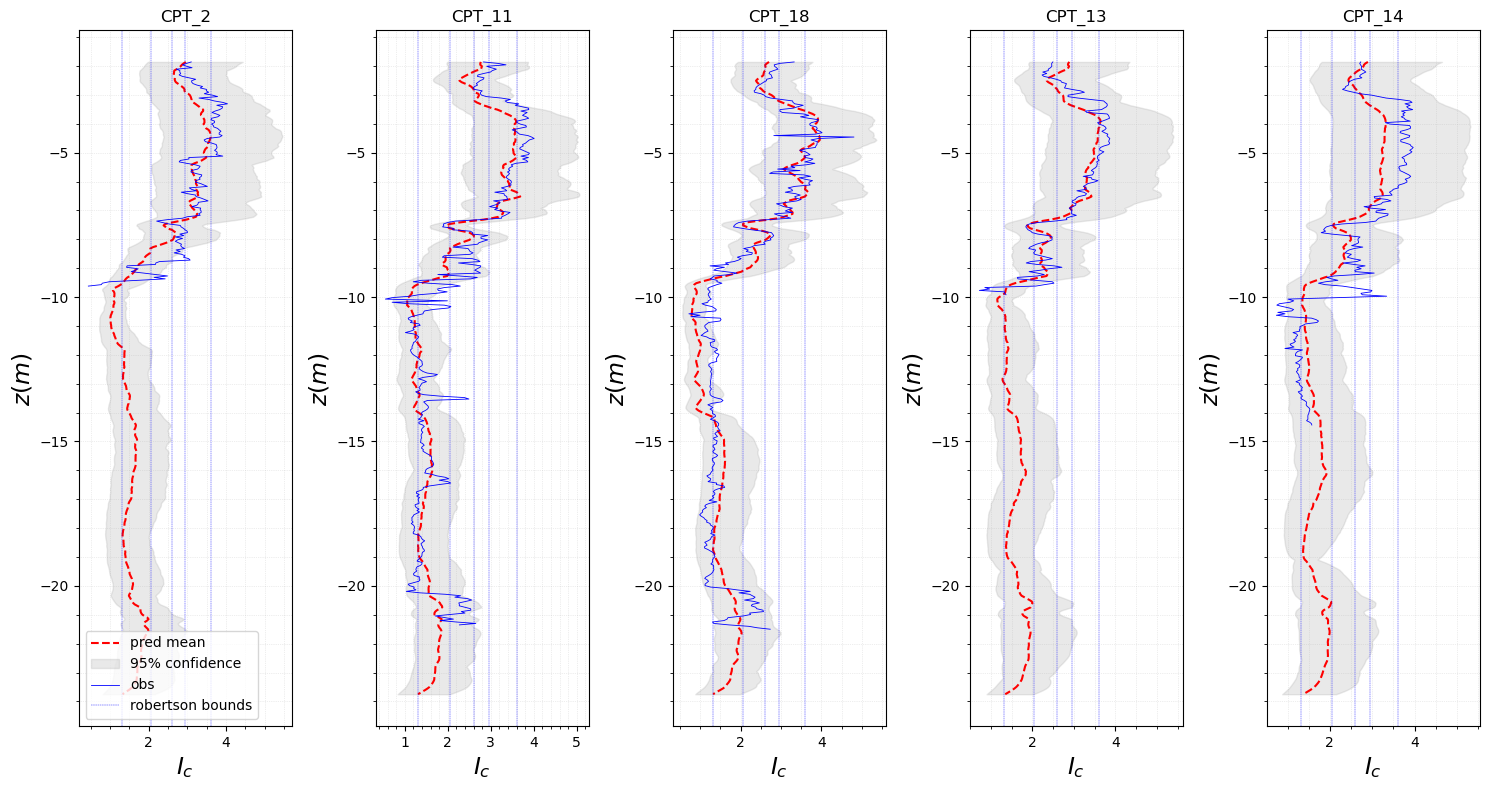

In [46]:
# =============================================================================
# Plots
# =============================================================================

par = "I_c"
bounds = [1.31, 2.05, 2.6, 2.95, 3.6]
from matplotlib.ticker import AutoMinorLocator
task_names = [r'$I_c$']
fig, axs = plt.subplots(1, len(x_t), figsize=(15, 8))
for i, ax in enumerate(axs):
    cut_id = i
    ax.plot(mean_pred.reshape(n_h, n_v).T[:, cut_id], 
            -(z_t*(Dz+depth_0)+depth_0), '--',  color='red', label='pred mean')
    # Shade in confidence
    ax.fill_betweenx( -(z_t*(Dz+depth_0)+depth_0), upper_Z.reshape(n_h, n_v).T[:, cut_id], 
  lower_Z.reshape(n_h, n_v).T[:, cut_id], 
   color = "darkgrey", alpha = 0.25 , label='95% confidence')                   
    # plt.gca().invert_yaxis()
    # ax.set_ylim([-3, 3])
    ax.plot(np.exp(data_test[:, cut_id]), -(z_t*(Dz+depth_0)+depth_0), '-', color='blue', linewidth = 0.6, label='obs')
        # ax.plot((data_test[task][:, cut_id]), -z_test, 'o', color='blue',
        #         markersize = 1.0, label='observations')
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    
    if par == "Ic":
        for xc in bounds:
            if xc == bounds[0]:
                ax.axvline(x=xc, linestyle = "dashed", color='blue', 
                   linewidth = 0.3, label = "robertson bounds")
            else:
                ax.axvline(x=xc, linestyle = "dashed", color='blue', 
                   linewidth = 0.3)
        
    ax.grid(which="both", color="darkgrey", alpha=.4, linewidth=0.5,linestyle=":")
    #plt.gca().invert_yaxis()
    ax.set_ylabel(r'$z (m)$ ', fontstyle='italic',fontsize = 17)
    ax.set_xlabel(task_names[0], fontstyle='italic',fontsize = 17)
    # ax.legend(['Observed Data', 'Mean', 'Confidence'])
    if i==0:
        ax.legend()
        # ax.set_xlim(0,3)

    ax.set_title("test_loc_"+str(i))
     # plt.gca().invert_yaxis()
#     fig.tight_layout()
fig.tight_layout()

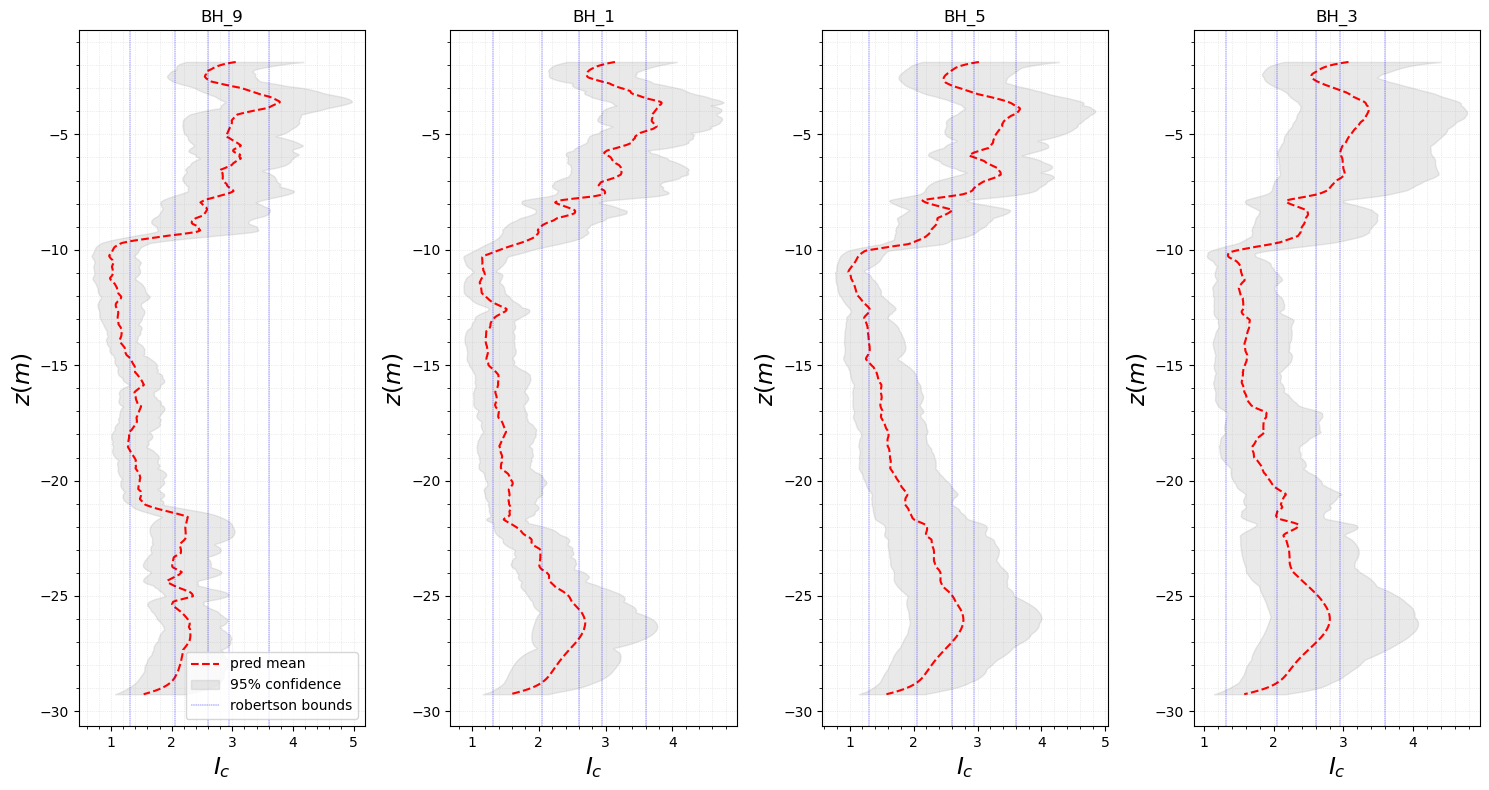

In [16]:
# -------------------------------------------------------------------------
# At borehole locations
# xcoords (BH_9,BH_1,H_5,BH_3) = [55.7300 104.2000 149.7200 192.4700] m
# ycoords (BH_9,BH_1,H_5,BH_3) = [16.1100 71.5800 21.6400 70.8200] m


x_p_m = np.array([0.27609611, 0.51622492, 0.74173892, 0.95352985])       # the scaled (divided by Dx) locations of the verification boreholes 
y_p_m = np.array([0.07981174, 0.35461977, 0.10720832, 0.35085459])       # the scaled (divided by Dx) locations of the verification boreholes 
z_t = np.linspace(0, np.max(grid[0].numpy()), 1000)
x_t = x_p_m
y_t = y_p_m

n_v = len(z_t)
n_h = len(x_t)

N = n_v * n_h


grid_test = [torch.from_numpy(z_t), 
             torch.from_numpy(x_t), 
             torch.from_numpy(y_t)]


test_zx = gpytorch.utils.grid.create_data_from_grid([grid_test[0], grid_test[1]])
test_zy = gpytorch.utils.grid.create_data_from_grid([grid_test[0], grid_test[2]])
test_x = torch.stack([test_zx[:,0].view(-1,1), 
                       test_zx[:,1].view(-1,1), 
                       test_zy[:,1].view(-1,1)]).to(device).squeeze().t().to(dtype)

model.eval()
likelihood.eval()    

with torch.no_grad(), gpytorch.settings.fast_pred_var(True), gpytorch.settings.fast_computations(
        covar_root_decomposition=False, log_prob=True, solves=False),\
    gpytorch.settings.use_toeplitz(False):
    # test_x = torch.linspace(0, 1, 51)
    observed_pred = likelihood(model(test_x))
    lower, upper = observed_pred.confidence_region()
    sigma = observed_pred.variance.sqrt()
    mean = observed_pred.mean
    
mean = mean.cpu()
sigma = sigma.cpu()
lower = lower.cpu()
upper = upper.cpu()
train_x_cpts = train_x_cpts.cpu()
train_y = train_y.cpu()
test_x = test_x.cpu()

mean_pred = np.exp(mean.numpy()*std_cpt_log + mu_cpt_log)

lower_Z = np.exp(lower.numpy()*std_cpt_log + mu_cpt_log)
upper_Z = np.exp(upper.numpy()*std_cpt_log + mu_cpt_log)

depth_or = z_t*(Dz)+depth_0



BH_locs = ["BH_9", "BH_1", "BH_5", "BH_3"]   # with respect to x (see excel file)

bounds = [1.31, 2.05, 2.6, 2.95, 3.6]
par = "Ic"
from matplotlib.ticker import AutoMinorLocator
task_names = [r'$I_c$']
fig, axs = plt.subplots(1, len(x_t), figsize=(15, 8))
for i, ax in enumerate(axs):
    cut_id = i
    ax.plot(mean_pred.reshape(n_h, n_v).T[:, cut_id], 
            -(depth_or), '--',  color='red', label='pred mean')
    ax.fill_betweenx( -(depth_or), upper_Z.reshape(n_h, n_v).T[:, cut_id], 
                     lower_Z.reshape(n_h, n_v).T[:, cut_id], 
   color = "darkgrey", alpha = 0.25 , label='95% confidence')                   

    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    
    if par == "Ic":
        for xc in bounds:
            if xc == bounds[0]:
                ax.axvline(x=xc, linestyle = "dashed", color='blue', 
                   linewidth = 0.3, label = "robertson bounds")
            else:
                ax.axvline(x=xc, linestyle = "dashed", color='blue', 
                   linewidth = 0.3)
        
    ax.grid(which="both", color="darkgrey", alpha=.4, linewidth=0.5,linestyle=":")
    ax.set_ylabel(r'$z (m)$ ', fontstyle='italic',fontsize = 17)
    ax.set_xlabel(task_names[0], fontstyle='italic',fontsize = 17)
    if i==0:
        ax.legend()

    ax.set_title(BH_locs[i])

fig.tight_layout()